# 4.2.3 オフ方策評価における推定量のハイパーパラメータチューニング
参考文献
- Yi Su, Maria Dimakopoulou, Akshay Krishnamurthy, and Miroslav Dudík. [Doubly Robust Off-Policy Evaluation with Shrinkage](https://arxiv.org/abs/1907.09623). ICML2021.
- Yi Su, Pavithra Srinath, and Akshay Krishnamurthy. [Adaptive Estimator Selection for Off-Policy Evaluation](https://arxiv.org/abs/2002.07729). ICML2021.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDatasetWithActionEmbeds as SyntheticBanditDataset,
    logistic_polynomial_reward_function,
)
from obp.ope import (
    OffPolicyEvaluation,
    InverseProbabilityWeighting as CIPS,
    InverseProbabilityWeightingTuning as CIPSTuning,
)
from utils import eps_greedy_policy, aggregate_simulation_results


In [2]:
print(obp.__version__)


0.5.5


### ログデータのサイズ$n$を変化させたときのCIPS推定量（固定のハイパーパラメータ および ハイパーパラメータを自動チューニングする場合）の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [3]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_context = 10 # 特徴量xの次元
num_actions = 500 # 行動数, |A|
reward_std = 2 # 報酬のノイズの大きさ
eps = 0.05 # 評価方策のパラメータ
test_data_size = 100000 # 評価方策の真の性能を近似するためのテストデータのサイズ
random_state = 12345
num_data_list = [500, 1000, 2000, 4000] # ログデータのサイズ

In [4]:
result_df_list = []
for beta in [5, -5]:
    ## 人工データ生成クラス
    dataset = SyntheticBanditDataset(
        n_actions=num_actions,
        dim_context=dim_context,
        beta=beta,
        reward_function=logistic_polynomial_reward_function,
        reward_type="continuous",
        reward_std=reward_std,
        random_state=random_state,
    )

    ## 評価方策の真の性能(policy value)を近似するためのテストデータ
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_data_size)

    ## 評価方策の真の性能(policy value)を近似
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        action_dist=eps_greedy_policy(
            test_data["expected_reward"], eps=eps,
        )[:, :, np.newaxis],
    )

    result_df_list_temp = []
    for num_data in num_data_list:
        estimated_policy_value_list = []
        for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
            ## データ収集方策が形成する分布に従いログデータを生成
            offline_logged_data = dataset.obtain_batch_bandit_feedback(
                n_rounds=num_data
            )

            ## ログデータ上における評価方策の行動選択確率を計算
            pi = eps_greedy_policy(offline_logged_data["expected_reward"], eps=eps)

            ## ログデータを用いてオフ方策評価を実行する
            ope = OffPolicyEvaluation(
                bandit_feedback=offline_logged_data,
                ope_estimators=[
                    CIPS(lambda_=10, estimator_name="10"),
                    CIPS(lambda_=1000, estimator_name="1000"),
                    CIPSTuning(
                        lambdas=np.arange(10, 1000, 10).tolist(),
                        tuning_method="mse", use_bias_upper_bound=False,
                        estimator_name="naive"
                    ),
                    CIPSTuning(
                        lambdas=np.arange(10, 1000, 10).tolist(),
                        tuning_method="slope", estimator_name="slope", delta=0.3
                    ),
                ]
            )
            estimated_policy_values = ope.estimate_policy_values(
                action_dist=pi[:, :, np.newaxis], # \pi(a|x)
            )
            estimated_policy_value_list.append(estimated_policy_values)

        ## シミュレーション結果を集計する
        result_df_list_temp.append(
            aggregate_simulation_results(
                estimated_policy_value_list, policy_value, "num_data", num_data,
            )
        )
    result_df_list.append(pd.concat(result_df_list_temp).reset_index(level=0))

num_data=4000...: 100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


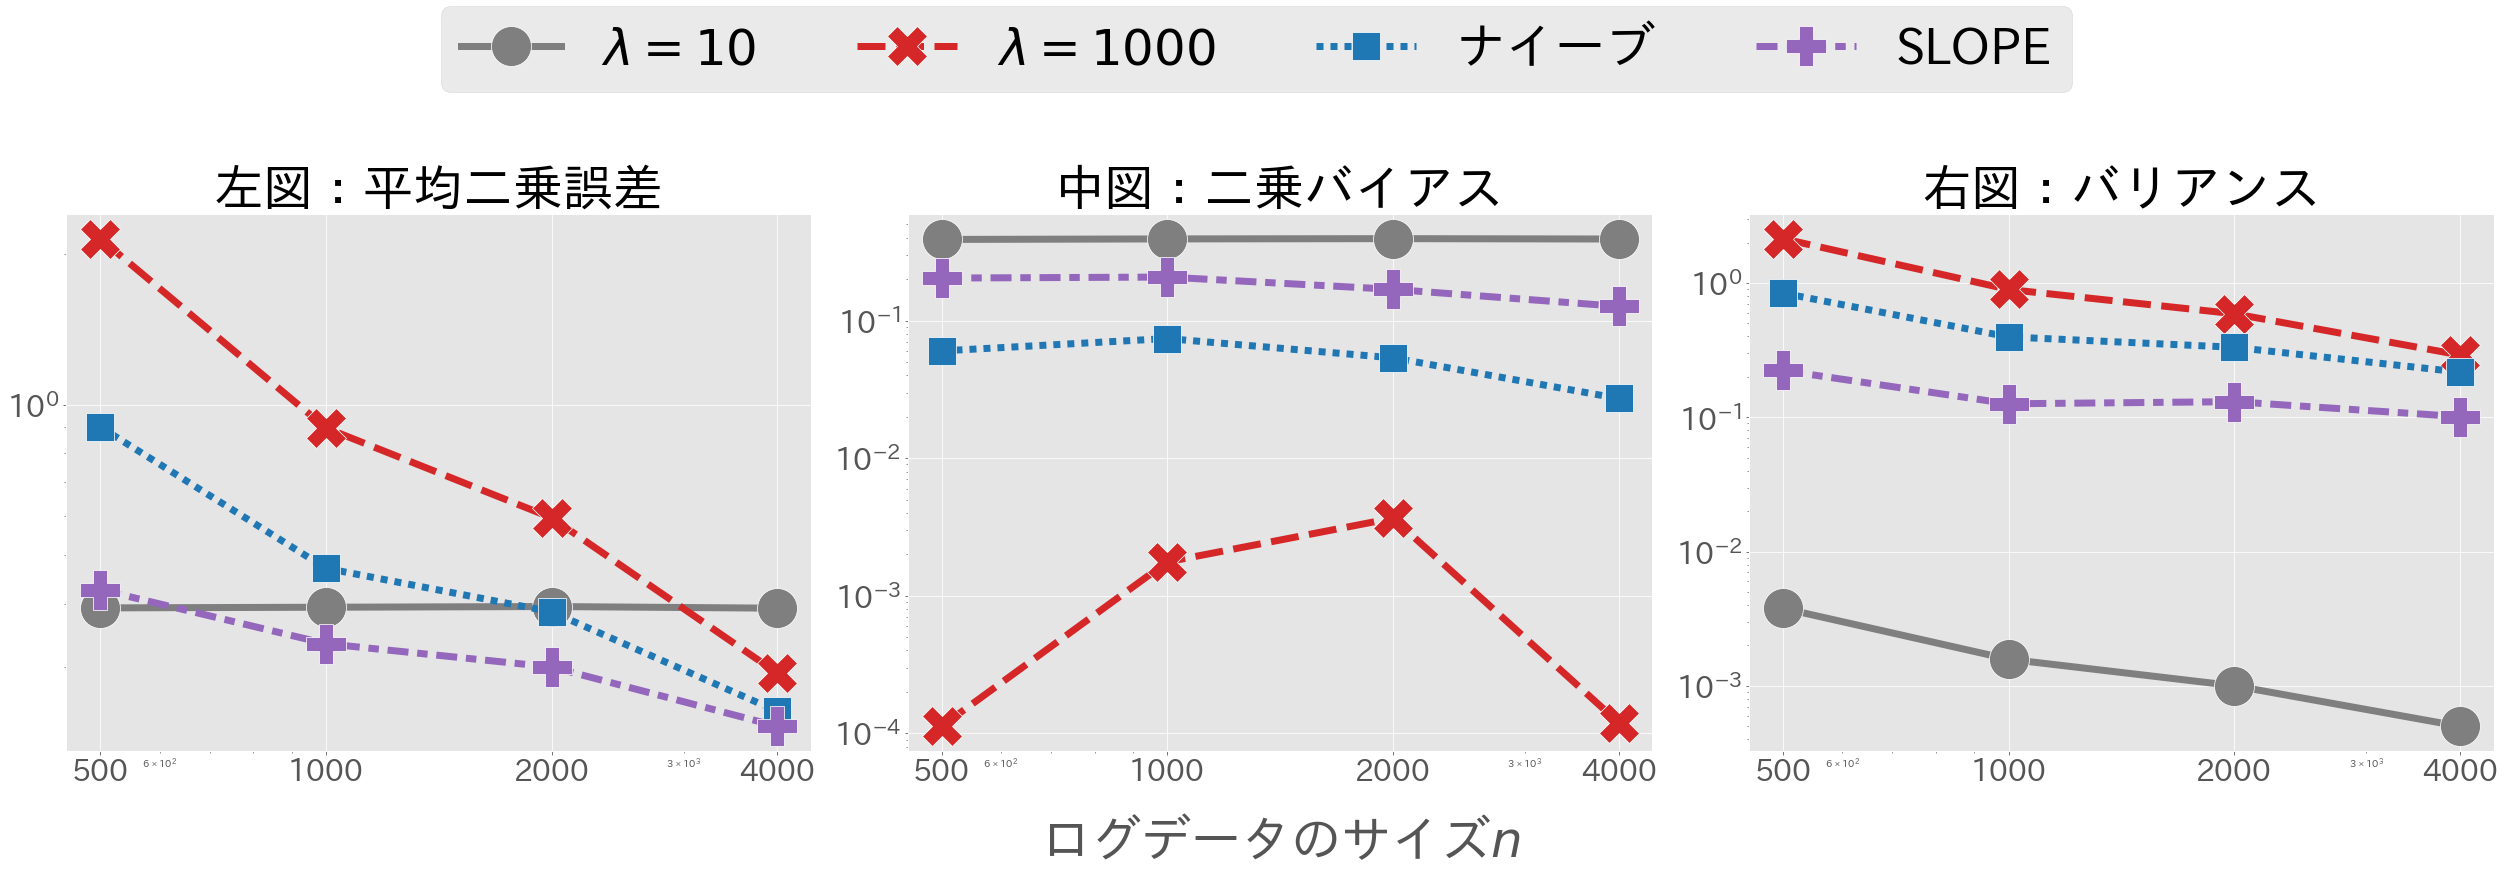

In [7]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red", "tab:blue", "tab:purple"],
        data=result_df_list[1],
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_yscale("log")
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["$\lambda=10$", "$\lambda=1000$", "ナイーブ", "SLOPE"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center",
)


## 図4.15

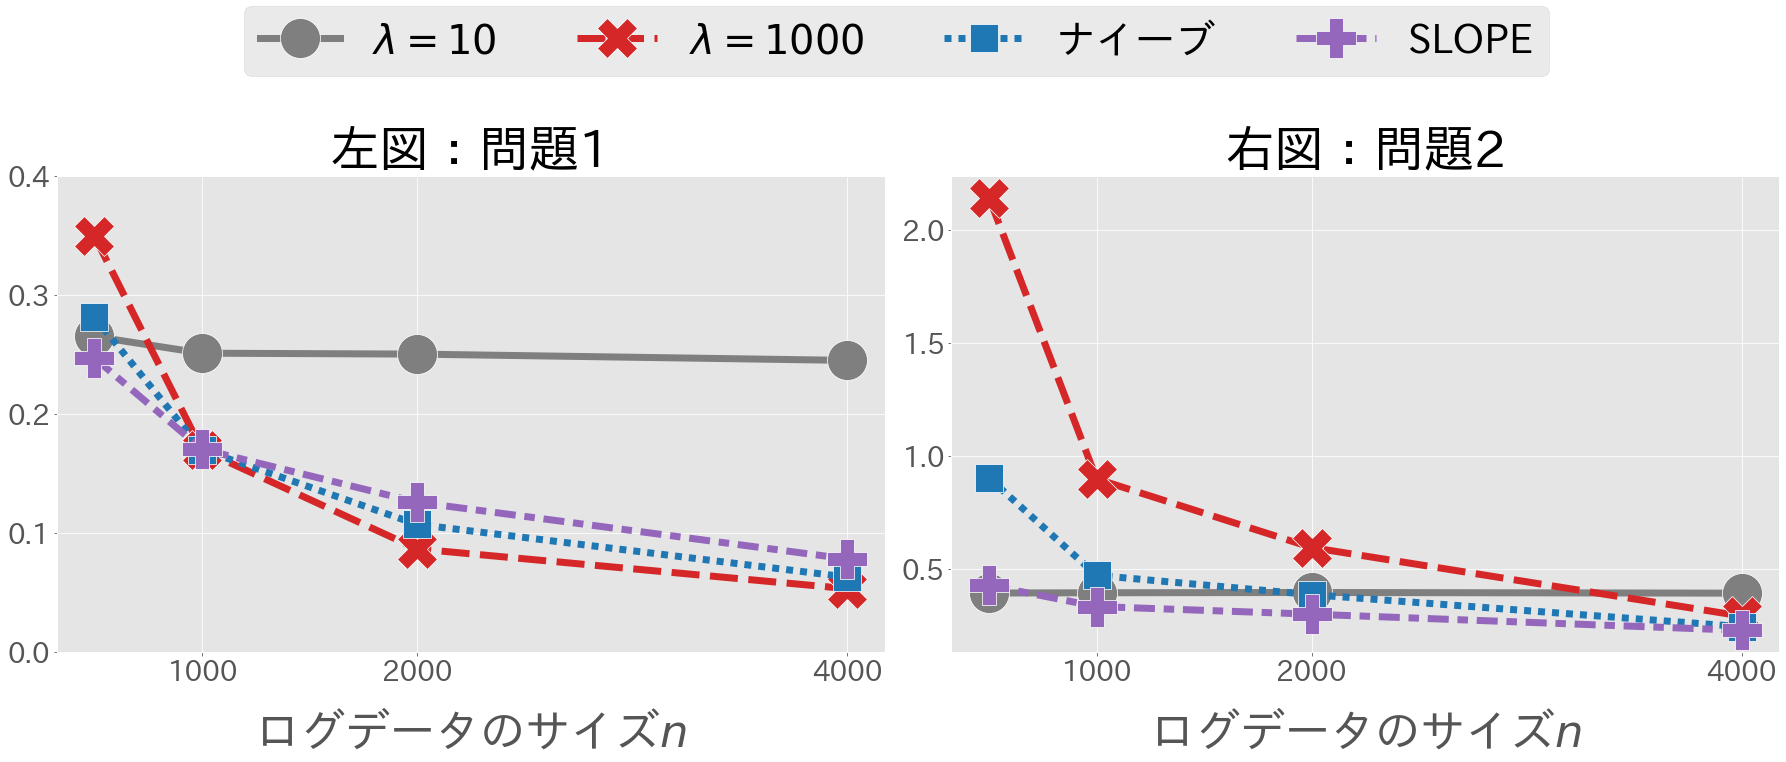

In [6]:
fig, ax_list = plt.subplots(1, 2, figsize=(25, 9), tight_layout=True)
title_dict = {2: "左図：問題1", 10: "右図：問題2"}
for i, (beta, result_df) in enumerate(zip([2, 10], result_df_list)):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_data",
        y="se",
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red", "tab:blue", "tab:purple"],
        data=result_df,
    )
    ax.set_title(title_dict[beta], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=28)
    if i ==0:
        ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=45)
    ax.set_xticks(num_data_list[1:])
    ax.set_xticklabels(num_data_list[1:], fontsize=28)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    ["$\lambda=10$", "$\lambda=1000$", "ナイーブ", "SLOPE"],
    fontsize=40, bbox_to_anchor=(0.5, 1.12), ncol=4, loc="center",
)
